In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from mmseg.models.losses.cross_entropy_loss import cross_entropy

In [5]:
cam = np.load('/media/ders/mazhiming/mmseg4wsss/mmsegmentation/save_npy/cam.npy')
depth_maps = np.load('/media/ders/mazhiming/mmseg4wsss/mmsegmentation/save_npy/depth_maps.npy')
labels = np.load('/media/ders/mazhiming/mmseg4wsss/mmsegmentation/save_npy/label.npy')
sal = np.load('/media/ders/mazhiming/mmseg4wsss/mmsegmentation/save_npy/sal.npy')

In [6]:
cam_tensor = torch.from_numpy(cam)
roll_cam_tensor = torch.roll(cam_tensor,shifts=1,dims=1)

depth_maps_tensor = torch.from_numpy(depth_maps)
labels_tensor = torch.from_numpy(labels)
sal_tensor = torch.from_numpy(sal)
b,h,w = labels.shape
roll_cam_tensor = F.interpolate(roll_cam_tensor,size=(h,w),mode='bilinear',align_corners=True)

In [7]:
cam_labels_ce_loss = cross_entropy(roll_cam_tensor,labels_tensor,ignore_index=255)
cam_labels_ce_loss

tensor(0.7968)

In [8]:
# roll_cam_tensor.size()
# >>> (8, 21, 448, 448)

# labels_tensor.size()
# >>> (8, 448, 448)

# depth_maps_tensor.size()
# >>> (8, 1, 448, 448)

reshape_depth_maps_tensor = depth_maps_tensor.view(8,448,448)

In [9]:
reshape_depth_maps_tensor = reshape_depth_maps_tensor.long()

In [10]:
# 提取labels_tensor的元素集合
labels_tensor_set = torch.unique(labels_tensor)

# 提取depth_maps_tensor的元素集合
depth_maps_tensor_set = torch.unique(reshape_depth_maps_tensor)

print(labels_tensor_set)
print()
print(depth_maps_tensor_set)

tensor([  0,   1,   5,   7,  11,  14,  15, 255])

tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,  15,
         17,  18,  19,  20,  22,  23,  25,  26,  27,  29,  30,  32,  33,  34,
         35,  37,  38,  39,  41,  42,  43,  44,  45,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 152, 153,
        154, 156, 157, 158, 160, 161, 162, 164, 165, 166, 168, 169, 171, 172,
        174, 175, 177, 178, 180, 181, 183, 185, 186, 188, 189, 191, 193, 195,
        197, 1

In [11]:
# 对depth做像素级聚类
# step1. 提取每个像素点的信息，包括深度值和x,y坐标
import pandas as pd
data = {'depth':[],'x':[],'y':[]}
for i in range(448):
    for j in range(448):
        depth = reshape_depth_maps_tensor[1][i][j]
        x = i
        y = j
        data['depth'].append(depth)
        data['x'].append(x)
        data['y'].append(y)
df = pd.DataFrame(data)

# step2. 对每个像素点的深度值进行归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['depth'] = scaler.fit_transform(df[['depth']])

# step3. 对每个像素点的x,y坐标进行归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['x','y']] = scaler.fit_transform(df[['x','y']])

# step3.1 增大深度值的权重
df['depth'] = df['depth']*15

# step4. 对每个像素点的信息进行聚类
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8,random_state=0).fit(df)
df['label'] = kmeans.labels_

# step5. 将聚类结果转换为tensor
df_tensor = torch.from_numpy(df['label'].values.reshape(448,448))

/media/soft/mzm/miniconda3/envs/wsss_mmseg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: cannot reshape array of size 150080 into shape (448,448)

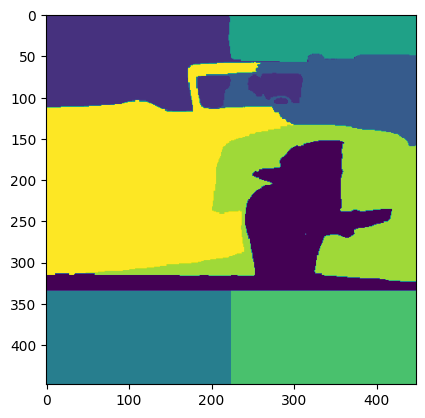

In [ ]:
# 可视化聚类结果
import matplotlib.pyplot as plt
plt.imshow(df_tensor)

In [ ]:
cam_depth_maps_ce_loss = cross_entropy(roll_cam_tensor,reshape_depth_maps_tensor,ignore_index=255)
cam_depth_maps_ce_loss

IndexError: Target 80 is out of bounds.